In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
os.chdir('/content/drive/My Drive/Case Study I')

In [3]:
data = pd.read_csv('train.tsv',sep='\t')
print("Data Shape : ", data.shape)
data.head()

Data Shape :  (1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


So we have around 1.48 Million Training Data points where each data point is made up of
* train_id : Unique Id to identify a Data Point
* name : Name of the Product in short
* Category_Name : The Category under which the Product falls into.
* Brand Name : Name of the Brand the Product belongs to
* Price : The Price of the Product
* Shipping : A boolean variable indicating whether the Shipping price will be paid by seller or buyer
* Item Description : A text summary describing the product in much detail.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


From the Above Information we can see that the number of Null Entries in Columns are
* Brand = 632682 
* Category Name = 6327
* Item Description = 4

The Important thing to note is that our Predictor Column "Price" does not contain any Null values

## EDA on Price

In [5]:
data['price'].describe().apply(lambda x: format(x, 'f'))

# As we can see that 75% of the Price falls are less than or equal to 29 while the maximum
# Price is 2009, so there is huge disparity in the distribution of Price column

count    1482535.000000
mean          26.737516
std           38.586066
min            0.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2009.000000
Name: price, dtype: object

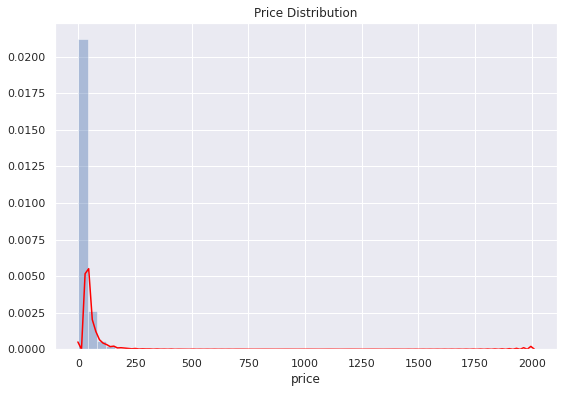

In [6]:
# Reference : https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
sns.set(rc={'figure.figsize':(9,6)})
sns.distplot(data.price, kde_kws = {"color" : "red"})
plt.title('Price Distribution')
plt.show()

Observation :
We can see that the Price Distribution is left skewed in Nature and Majority of Values are less than 100.

In [0]:
prices = data.price.values # Saving the Price Values in a Numpy array
prices.sort()

In [8]:
for i in range(1,11):
  percentile_value = np.percentile(prices,i*10)
  print(i*10," th Percentile Value : ", percentile_value)

10  th Percentile Value :  7.0
20  th Percentile Value :  10.0
30  th Percentile Value :  12.0
40  th Percentile Value :  14.0
50  th Percentile Value :  17.0
60  th Percentile Value :  20.0
70  th Percentile Value :  26.0
80  th Percentile Value :  34.0
90  th Percentile Value :  51.0
100  th Percentile Value :  2009.0


In [9]:
for i in range(1,10):
  percentile_value = np.percentile(prices,90 + i)
  print(90 + i," th Percentile Value : ", percentile_value)

91  th Percentile Value :  55.0
92  th Percentile Value :  58.0
93  th Percentile Value :  62.0
94  th Percentile Value :  67.0
95  th Percentile Value :  75.0
96  th Percentile Value :  85.0
97  th Percentile Value :  99.0
98  th Percentile Value :  122.0
99  th Percentile Value :  170.0


In [10]:
for i in range(1,11):
  percentile_value = np.percentile(prices,99 + i*0.1)
  print(99 + i*0.1," th Percentile Value : ", percentile_value)

99.1  th Percentile Value :  180.0
99.2  th Percentile Value :  189.0
99.3  th Percentile Value :  200.0
99.4  th Percentile Value :  210.0
99.5  th Percentile Value :  230.3300000000745
99.6  th Percentile Value :  256.0
99.7  th Percentile Value :  286.0
99.8  th Percentile Value :  340.0
99.9  th Percentile Value :  450.0
100.0  th Percentile Value :  2009.0


From the above three Cells we can see that upto 99.3% of the Price value are less than or equal to 200 which could be our inflection point, while the Maximum Price is 2009.

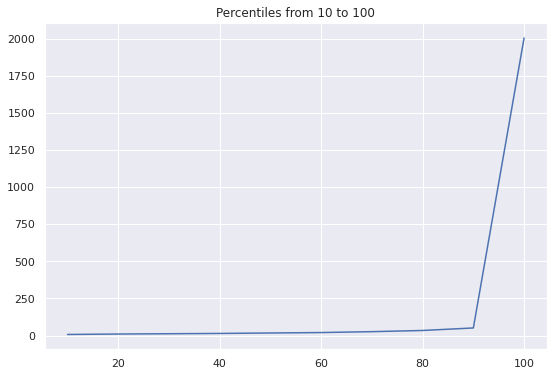

In [11]:
y_axis = []
x_axis = []
for i in range(1,11):
  percentile_value = np.percentile(prices,i*10)
  y_axis.append(percentile_value)
  x_axis.append(i*10)

plt.plot(x_axis,y_axis)
plt.title("Percentiles from 10 to 100")
plt.show()

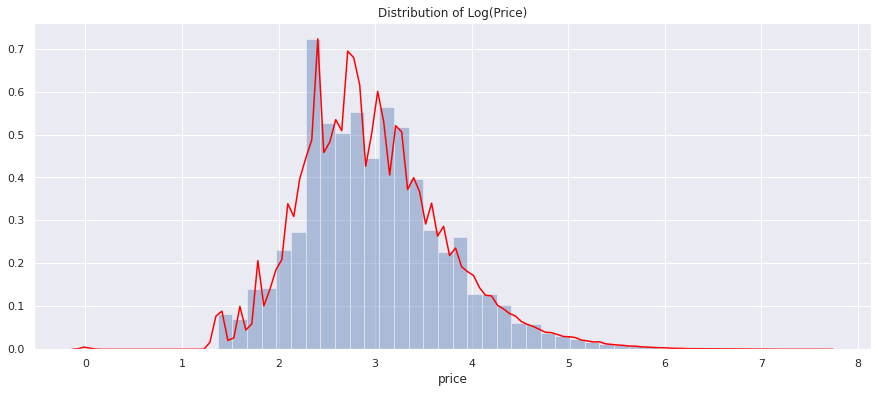

In [12]:
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(np.log1p(data.price), kde_kws = {"color" : "red"})
plt.title('Distribution of Log(Price)')
plt.show()

The Log values of Price Results in somewhat close to Normal Distribution which can help us future.

### Check for Rows having Invalid Price values

In [13]:
negative_price = len(data[data.price<=0])
print("Number of Rows having Price less than or equal to 0 are : ", negative_price)

Number of Rows having Price less than or equal to 0 are :  874


In [14]:
# Hence Removing them 
data = data[data.price > 0].reset_index(drop=True)
print(data.shape)

(1481661, 8)


### EDA on Shipping

Shipping is a boolean value where
* value = 0 means shipping price is paid by buyer
* value = 1 means shipping price is paid by seller

In [15]:
data.groupby('shipping')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
shipping,,,,,,,,
0,818961.0,26.759558,38.382572,3.0,10.0,17.0,29.0,2009.0
1,662700.0,26.745540,38.849231,3.0,10.0,17.0,29.0,2006.0


There is not much difference around the mean price irespective of what value the shipping column has.
To conclude it further let's try violin-plot to confirm it.

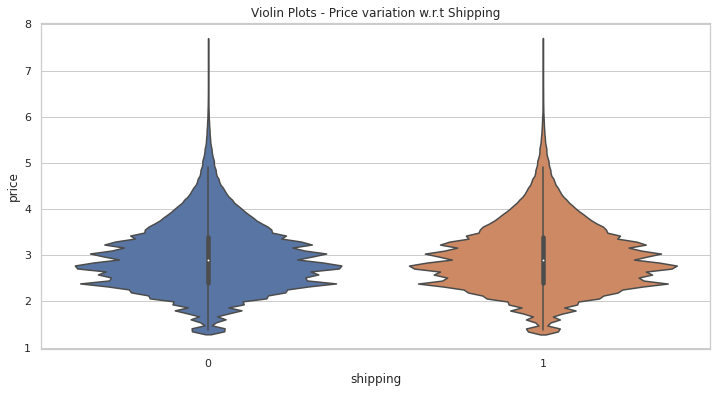

In [16]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
sns.violinplot(x=data.shipping, y=np.log1p(data.price))
plt.title('Violin Plots - Price variation w.r.t Shipping')
plt.show()

Here since there is huge disparity in the Price values I have taken log values of the Price Column and we can see that 25,50 and 75th percentiles of Log(Price) values is almost equal when shipping is taken into consideration

### EDA on Item Condition

In [17]:
data.groupby('item_condition_id')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
1,640149.0,26.769953,38.599212,3.0,10.0,17.0,29.0,2009.0
2,375274.0,26.746050,38.934424,3.0,10.0,17.0,29.0,2004.0
3,431911.0,26.746554,38.373124,3.0,10.0,17.0,29.0,2006.0
4,31945.0,26.575677,37.176963,3.0,10.0,17.0,29.0,1315.0
5,2382.0,27.018052,40.629001,3.0,10.0,16.0,29.0,784.0


From the Description we can see that Item_condition_id is Categorical Column having 5 values with value = 1 being the most occured one while value = 5 having the least occurence. 

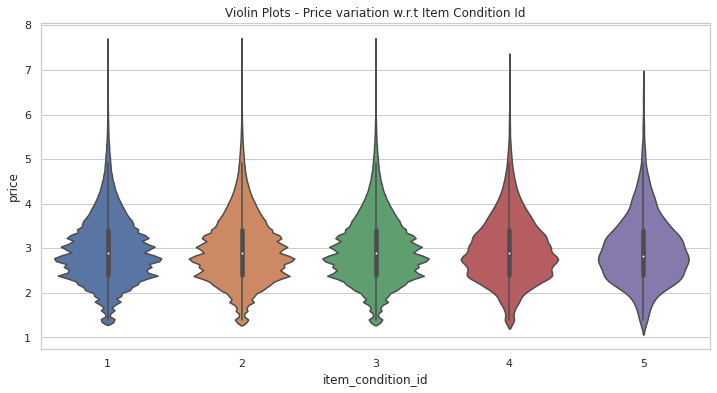

In [18]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
sns.violinplot(x=data.item_condition_id, y=np.log1p(data.price))
plt.title('Violin Plots - Price variation w.r.t Item Condition Id')
plt.show()

From the above Violin Plot the 25th,50th and 75th Percentile of the Log(Price) is alomost same when Item condition is taken into consideration.
The minor difference is the Max value of Price when Item_Condition_id = 5 is much less when compared with the Price value for other Item_condition_Id's.

### EDA on Brand

In [19]:
null_values = data.brand_name.isnull().sum()
percentage_value = np.round(null_values/data.shape[0],4) * 100
print("Percentage of Data out of Total Data having Null/Missing Value in Brand Column ", percentage_value, "%")

Percentage of Data out of Total Data having Null/Missing Value in Brand Column  42.68 %


In [20]:
# Table of Brand Name along with the Average Price Per Brand and their Total Occurence
brands_df = pd.DataFrame(data.groupby('brand_name', as_index=False).agg({'price': 'mean','shipping' : 'count'}))
brands_df.columns = ['brand_name','avg_price','count']
brands_df = brands_df.sort_values(by=['count'],ascending = False)

print(brands_df.shape)
brands_df.head(10)

(4809, 3)


,brand_name,avg_price,count
3221,PINK,26.717185,54060
3057,Nike,26.692024,54009
4504,Victoria's Secret,26.519090,48010
2604,LuLaRoe,26.875149,31013
267,Apple,26.925849,17316
1510,FOREVER 21,26.894439,15176
3067,Nintendo,26.104400,15000
2626,Lululemon,26.822670,14552
2841,Michael Kors,26.690625,13920
213,American Eagle,26.572561,13251


In [21]:
# Filling all the Missing/NUll values in brand_name with value "missing"
data['brand_name'] = data['brand_name'].fillna('missing').astype('category')
print(data.brand_name.isnull().sum())

0


### EDA on Item Description

In [22]:
print("Number of Missing Values in Item Description : ", data.item_description.isnull().sum())

Number of Missing Values in Item Description :  4


In [23]:
# Filling all the Missing/Null Values with "No Description" value
data["item_description"].fillna("No Description", inplace=True)
print("Number of Missing Values in Item Description : ", data.item_description.isnull().sum())

Number of Missing Values in Item Description :  0


In [24]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [0]:
# Reference : Applied AI Course
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
stopwords = stopwords.words('english')
def preprocessing_desc(description):
  preprocessed_desc = []
  for sentence in tqdm(description.values):
        sentence = decontracted(sentence)
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_desc.append(sent.lower().strip())
  return preprocessed_desc

In [27]:
data["preprocessed_desc"] = preprocessing_desc(data["item_description"])

100%|██████████| 1481661/1481661 [01:37<00:00, 15147.52it/s]


Since Item Description is a Textual Column, we can use WordCloud to find the occurence strength of the words present in the Description

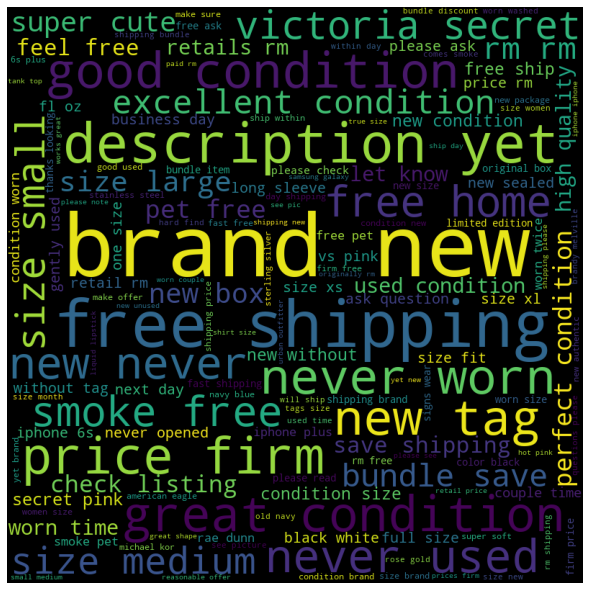

In [28]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,background_color = 'black',
                      min_font_size = 10).generate(" ".join(data.preprocessed_desc.astype(str)))
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

From the WordCloud we can see that majority of the words either talks about the condition of the Product or shipping condition or some other key details w.r.t to Products which I think are major factors while deciding the Price of the Product

### EDA on Name

In [29]:
print("Number of Missing Values in Name : ", data.name.isnull().sum())

Number of Missing Values in Name :  0


In [30]:
data["preprocessed_name"] = preprocessing_desc(data["name"])

100%|██████████| 1481661/1481661 [00:29<00:00, 49518.16it/s]


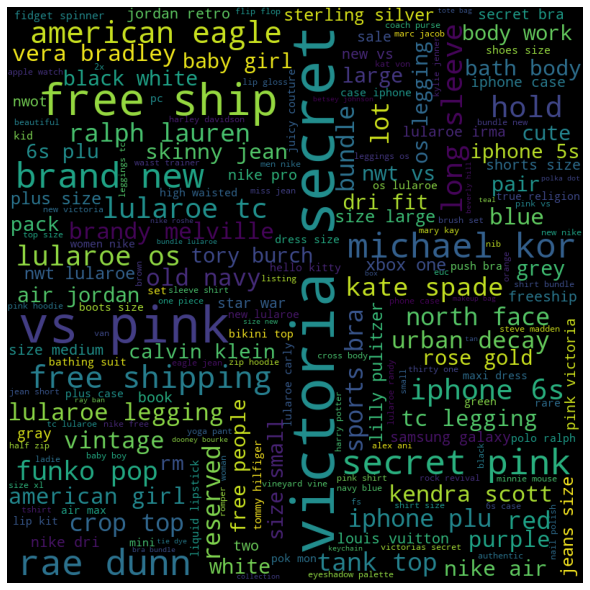

In [31]:
wordcloud = WordCloud(width = 800, height = 800,background_color = 'black',
                      min_font_size = 10).generate(" ".join(data.preprocessed_name.astype(str)))
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

From the WordCloud we can see that the name column most contains information related the Brand to which the Product belongs to.

### EDA on Category Name

In [32]:
print("Number of Missing Values in Category Name : ", data.category_name.isnull().sum())

Number of Missing Values in Category Name :  6324


In [33]:
# Filling all the Missing/Null Values with "missing" value
data["category_name"].fillna("missing", inplace=True)
print("Number of Missing Values in Category Name : ", data.category_name.isnull().sum())

Number of Missing Values in Category Name :  0


In [34]:
# Printing some Values from the Category Name Column
data.category_name.values

array(['Electronics/Video Games & Consoles/Games',
       'Women/Athletic Apparel/Pants, Tights, Leggings',
       'Vintage & Collectibles/Antique/Book', ...,
       'Sports & Outdoors/Exercise/Fitness accessories',
       'Home/Home Décor/Home Décor Accents',
       "Women/Women's Accessories/Wallets"], dtype=object)

As from the above output we can see that Category Name has multiple values in a cell, so we will be splitting/dividing the Category Name column into 3 sub-categories such as gencat_name, subcat1_name and subcat2_name

In [35]:
# Reference = https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns

data['gencat_name'],data['subcat1_name'],data['subcat2_name'] = data['category_name'].str.split('/', 2).str

print(data.shape)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


(1481661, 13)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,preprocessed_desc,preprocessed_name,gencat_name,subcat1_name,subcat2_name
0,874,Metal Gear Solid V: The Phantom Pain NEW,1,Electronics/Video Games & Consoles/Games,Xbox,3.0,1,Metal Gear Solid V: The Phantom Pain - Xbox One,metal gear solid v the phantom pain xbox one,metal gear solid v the phantom pain new,Electronics,Video Games & Consoles,Games
1,875,TC Black vintage camera leggings Lularoe,3,"Women/Athletic Apparel/Pants, Tights, Leggings",Independent,3.0,0,"Worn a few times, great condition. Unicorn print.",worn times great condition unicorn print,tc black vintage camera leggings lularoe,Women,Athletic Apparel,"Pants, Tights, Leggings"
2,876,"Winnie-the-Poah, The Original Version",3,Vintage & Collectibles/Antique/Book,missing,3.0,0,This is an exact reproduction of the Original ...,this exact reproduction original winnie pooh p...,winnie poah the original version,Vintage & Collectibles,Antique,Book
3,877,Christian louboutin Tudor bal 100,3,Women/Shoes/Pumps,Christian Louboutin,3.0,0,"It's in great condition used, shoes have some ...",it great condition used shoes marks hard tell ...,christian louboutin tudor bal 100,Women,Shoes,Pumps
4,878,Large coach shoulder bag,3,Women/Women's Handbags/Shoulder Bag,Coach,3.0,0,Authentic coach signature monogrammed tye dye ...,authentic coach signature monogrammed tye dye ...,large coach shoulder bag,Women,Women's Handbags,Shoulder Bag


In [36]:
print("Number of Missing Values in Sub-Category 1 : ", data.subcat1_name.isnull().sum())

Number of Missing Values in Sub-Category 1 :  6324


In [37]:
print("Number of Missing Values in Sub-Category 2 : ", data.subcat2_name.isnull().sum())

Number of Missing Values in Sub-Category 2 :  6324


In [0]:
# Filling all the Missing/Null Values with "missing" value
data["subcat1_name"].fillna("missing", inplace=True)
data["subcat2_name"].fillna("missing", inplace=True)

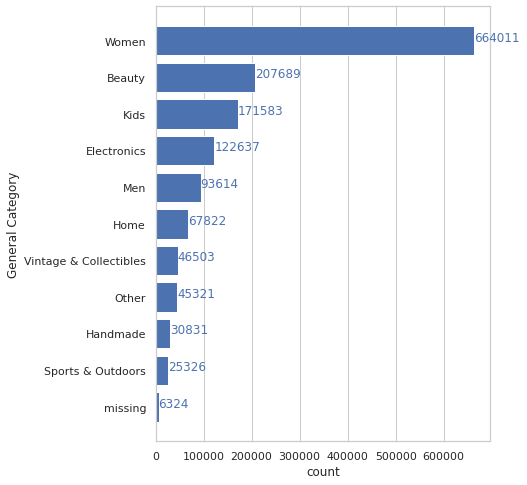

In [39]:
# Reference : https://towardsdatascience.com/mercari-price-suggestion-97ff15840dbd
gencat_count = Counter(list(data.gencat_name.values))
x, y = zip(*gencat_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('General Category')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

We can see that out of top 15 most General Category "Women" category has highest Number of Products.

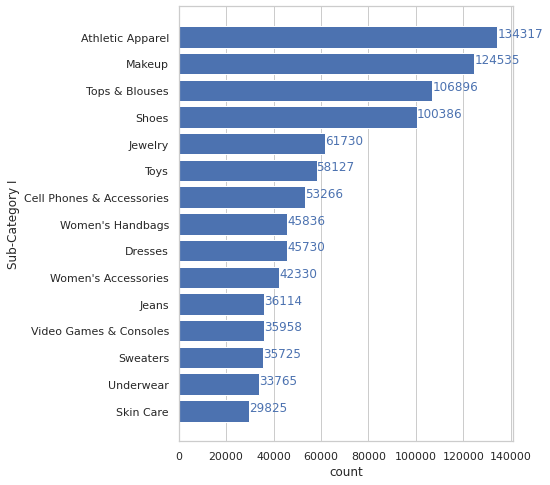

In [40]:
subcat1_count = Counter(list(data.subcat1_name.values))
x, y = zip(*subcat1_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Sub-Category I')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

There is a good Distribution among Sub-categories I categories where Atletic Apparel is the most occuring sub-category1

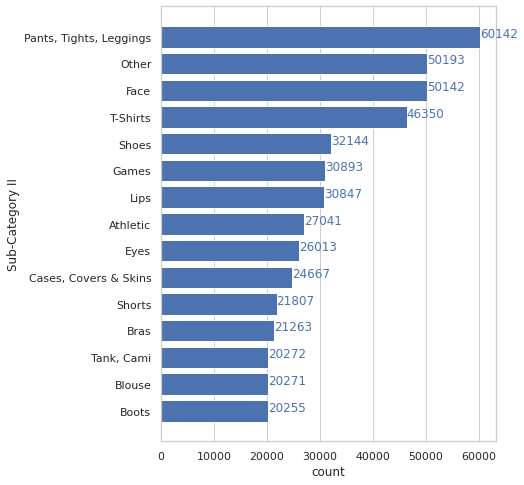

In [41]:
subcat2_count = Counter(list(data.subcat2_name.values))
x, y = zip(*subcat2_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Sub-Category II')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

There is a good Distribution among Sub-categories II categories where Pants,Tights,Leggings is the most occuring sub-category II

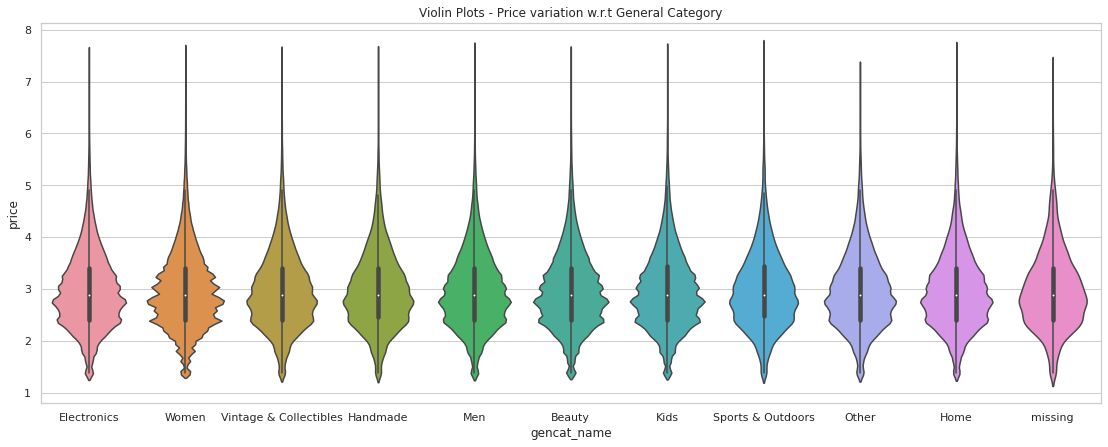

In [42]:
sns.set(style='whitegrid')
plt.figure(figsize=(19,7))
sns.violinplot(x=data.gencat_name, y=np.log1p(data.price))
plt.title('Violin Plots - Price variation w.r.t General Category')
plt.show()

In [43]:
data.groupby('gencat_name')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
gencat_name,,,,,,,,
Beauty,207689.0,26.756956,39.223420,3.0,10.00,17.0,29.0,1900.0
Electronics,122637.0,26.811986,38.982350,3.0,10.00,17.0,29.0,1850.0
Handmade,30831.0,26.451672,35.491681,3.0,10.75,17.0,29.0,1800.0
Home,67822.0,26.763617,41.003440,3.0,10.00,17.0,29.0,2006.0
Kids,171583.0,26.763482,37.572725,3.0,10.00,17.0,30.0,2000.0
Men,93614.0,26.609978,38.157129,3.0,10.00,17.0,29.0,2000.0
Other,45321.0,26.587498,37.001968,3.0,10.00,17.0,29.0,1354.0
Sports & Outdoors,25326.0,27.358169,45.399650,3.0,11.00,17.0,30.0,2004.0
Vintage & Collectibles,46503.0,26.926220,41.036280,3.0,10.00,17.0,29.0,1808.0


From the above two Notebook Cells we can see that there is not much variation in Price with Respect to General Category taken under consideration.All the General Category have similar Mean Prices.

In [0]:
# Referenence Applied AI Course
def clean_categories(category):
  clean_value = []
  cat = list(category)
  for i in tqdm(cat):
    i = re.sub('[^A-Za-z0-9]+', ' ', i)
    i = i.replace(' ','')
    i = i.replace('&','_')
    clean_value.append(i.strip())
  
  return clean_value

In [45]:
# Cleaning up the Category Name sub-columns
data['gencat_name'] = clean_categories(data['gencat_name'].values)
data['subcat1_name'] = clean_categories(data['subcat1_name'].values)
data['subcat2_name'] = clean_categories(data['subcat2_name'].values)

100%|██████████| 1481661/1481661 [00:02<00:00, 578482.00it/s]


In [46]:
data.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'preprocessed_desc',
       'preprocessed_name', 'gencat_name', 'subcat1_name', 'subcat2_name'],
      dtype='object')

In [0]:
# Dropping off Columns not required
data.drop('train_id',axis = 1, inplace = True)
data.drop('name', axis = 1,inplace = True)
data.drop('category_name', axis = 1, inplace = True)
data.drop('item_description', axis = 1, inplace = True)

In [48]:
data.columns

Index(['item_condition_id', 'brand_name', 'price', 'shipping',
       'preprocessed_desc', 'preprocessed_name', 'gencat_name', 'subcat1_name',
       'subcat2_name'],
      dtype='object')

# Feature Engineering

In [49]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(data,test_size = 0.25)

print("Train Data Shape : ", train_data.shape)
print("Test Data Shape : ", test_data.shape)

Train Data Shape :  (1111245, 9)
Test Data Shape :  (370416, 9)


In [50]:
# Reference : https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755

# Since Mercari App doesn't allow any price to be lower than 3 or greater than 2000 removing
# such data points from training data

train_data = train_data[(train_data.price >= 3) & (train_data.price <= 2000)]
print(train_data.shape)

(1111244, 9)


### Transforming Price Column into Log Values

In [51]:
# Transforming Price to Log Values so as the distribution of Log values
# become somewhat Normal making it easy for ML models to predict

train_data['log_price'] = np.log1p(train_data['price'])
test_data['log_price'] = np.log1p(test_data['price'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Generating 7 new features based on Item Description

In [52]:
# Reference : https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th

# The above kernel Item Description into consideration and generate 7 new features like
# for each description words lengths, like percentage of upper-case words, hashtags, etc
# This was that the 3rd Reference I passed in the Google Docs

print('Generating features with statistics for item description textual content')

acronyms_regex = re.compile('([A-Z\-0-9]{2,})')
hashtag_regex = re.compile(r'(#[a-z]{2,})')

#Extracts statistics for each description, words lengths, like percentage of upper-case words, hashtags, etc
def extract_counts(text):
    text_size_words_counts = len(text.split(' '))
    text_size_words_log_counts = math.log1p(text_size_words_counts)
    full_uppercase_perc = len(acronyms_regex.findall(text)) / float(text_size_words_counts)
    exclamation_log_count = math.log1p(text.count('!'))
    star_log_count = math.log1p(text.count('*'))
    percentage_log_count = math.log1p(text.count('%'))
    price_removed_marker_log_count = math.log1p(text.count('[rm]'))
    hashtag_log_count = math.log1p(len(hashtag_regex.findall(text)))    
    return [text_size_words_log_counts,
            full_uppercase_perc,
            exclamation_log_count,
            star_log_count,            
            percentage_log_count,
            price_removed_marker_log_count,
            hashtag_log_count]

Generating features with statistics for item description textual content


In [53]:
# On Training Data
item_descr_counts = np.vstack(train_data['preprocessed_desc'].astype(str).apply(extract_counts).values)
item_descr_counts_scaler = StandardScaler(copy=True)
train_desc_feats = item_descr_counts_scaler.fit_transform(item_descr_counts)
print(train_desc_feats.shape)

(1111244, 7)


In [54]:
# On Test Data
item_descr_counts = np.vstack(test_data['preprocessed_desc'].astype(str).apply(extract_counts).values)
item_descr_counts_scaler = StandardScaler(copy=True)
test_desc_feats = item_descr_counts_scaler.fit_transform(item_descr_counts)
print(test_desc_feats.shape)

(370416, 7)


### Sentiment Score on Textual Columns

In [0]:
# Ref : https://towardsdatascience.com/mercari-price-recommendation-for-online-retail-sellers-979c4d07f45c
# This blog suggests to calculate Sentiment Scores from textual columns like Name and Description
# because better the sentiment score higher are the chances of buyers buying them.
# Ref : https://stackoverflow.com/questions/60122247/how-can-we-do-a-sentiment-analysis-and-create-a-sentiment-record-next-to-each

def sentiment_score(text_values):
  sid = SentimentIntensityAnalyzer()
  scores = []
  for sentence in tqdm(text_values):
    score = sid.polarity_scores(sentence)
    scores.append(score['compound'])
  
  return scores

In [56]:
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [57]:
# On Name Column
train_sentiment_name = sentiment_score(train_data['preprocessed_name'])
train_data['sentiment_score_name'] = train_sentiment_name

test_sentiment_name = sentiment_score(test_data['preprocessed_name'])
test_data['sentiment_score_name'] = test_sentiment_name

100%|██████████| 370416/370416 [00:21<00:00, 16917.56it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
#On Description Column
train_sentiment_desc = sentiment_score(train_data['preprocessed_desc'])
train_data['sentiment_score_desc'] = train_sentiment_desc

test_sentiment_desc = sentiment_score(test_data['preprocessed_desc'])
test_data['sentiment_score_desc'] = test_sentiment_desc

100%|██████████| 370416/370416 [01:25<00:00, 4339.98it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
"""
On Grouping Category Name, Brand Name and Shipping we will create 8 new features
with respect to Price like Price_Mean, Price_Median, Price_Std_Deviation, Minimum and
Maximum Price per group
"""
# Reference : https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th

'\nOn Grouping Category Name, Brand Name and Shipping we will create 8 new features\nwith respect to Price like Price_Mean, Price_Median, Price_Std_Deviation, Minimum and\nMaximum Price per group\n'

In [0]:
# Reference : https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def generate_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "log_price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_count',
                                                              'cbs_log_price_mean',
                                                              'cbs_log_price_std',
                                                              'cbs_log_price_conf_variance',
                                                              'cbs_min_expected_log_price',
                                                              'cbs_max_expected_log_price',
                                                              'cbs_log_price_min',
                                                              'cbs_log_price_max']].fillna(0).values
    
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [61]:
train_data['cat_brand_ship'] = (train_data['gencat_name'].astype(str) + "/" + 
                                train_data['subcat1_name'].astype(str) + "/" +
                                train_data['subcat2_name'].astype(str) + "_" +
                                train_data['brand_name'].astype(str) + "_" +  
                                train_data['shipping'].astype(str))
test_data['cat_brand_ship'] = (test_data['gencat_name'].astype(str) + "/" + 
                               test_data['subcat1_name'].astype(str) + "/" +
                               test_data['subcat2_name'].astype(str) + "_" +
                              test_data['brand_name'].astype(str) + "_" +  
                              test_data['shipping'].astype(str))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [62]:
train_cbs_features = generate_cbs_stats(train_data,train_data)
test_cbs_features = generate_cbs_stats(train_data,test_data)
print("New Train CBS Features Shape : ", train_cbs_features.shape)
print("New Test CBS Features Shape : ", test_cbs_features.shape)

New Train CBS Features Shape :  (1111244, 8)
New Test CBS Features Shape :  (370416, 8)


### Concatenating all the above 17 features along with Log Price to see the corrleation values

In [0]:
new_df = pd.concat([pd.DataFrame(train_desc_feats,
                                  columns = ['text_size_words_log_counts','full_uppercase_perc','exclamation_log_count',
                                             'star_log_count','percentage_log_count','price_removed_marker_log_count',
                                             'hashtag_log_count']),
                    pd.DataFrame(generate_cbs_stats(train_data,train_data),
                                  columns = ['cbs_log_count','cbs_log_price_mean','cbs_log_price_std',
                                             'cbs_log_price_conf_variance','cbs_min_expected_log_price',
                                             'cbs_max_expected_log_price','cbs_log_price_min','cbs_log_price_max']),
                    train_data[['sentiment_score_name','sentiment_score_desc']].reset_index(drop = True),
                    train_data['log_price'].reset_index(drop = True)],axis = 1)

In [64]:
new_df.head()

,text_size_words_log_counts,full_uppercase_perc,exclamation_log_count,star_log_count,percentage_log_count,price_removed_marker_log_count,hashtag_log_count,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max,sentiment_score_name,sentiment_score_desc,log_price
0,-0.445184,-0.383726,0.0,0.0,0.0,0.0,0.0,1.439674,-0.099098,0.127549,0.161643,-0.191601,0.061019,-0.38125,0.945008,0.0,0.0000,5.153292
1,0.598849,-0.383726,0.0,0.0,0.0,0.0,0.0,0.445100,0.222192,0.314265,0.263741,-0.204814,0.357562,-0.38125,0.154995,0.0,0.3182,1.945910
2,-1.667634,-0.383726,0.0,0.0,0.0,0.0,0.0,0.359910,-0.102000,-0.011433,0.018184,-0.055950,-0.054739,-0.38125,0.115904,0.0,-0.2960,2.564949
3,-1.099227,-0.383726,0.0,0.0,0.0,0.0,0.0,0.463961,0.023435,0.378163,0.385971,-0.373740,0.321875,-0.38125,1.205285,0.0,0.0000,2.833213
4,-0.445184,1.593096,0.0,0.0,0.0,0.0,0.0,1.045527,0.007949,0.245959,0.254047,-0.251481,0.206108,-0.38125,0.824156,0.0,0.0000,2.833213


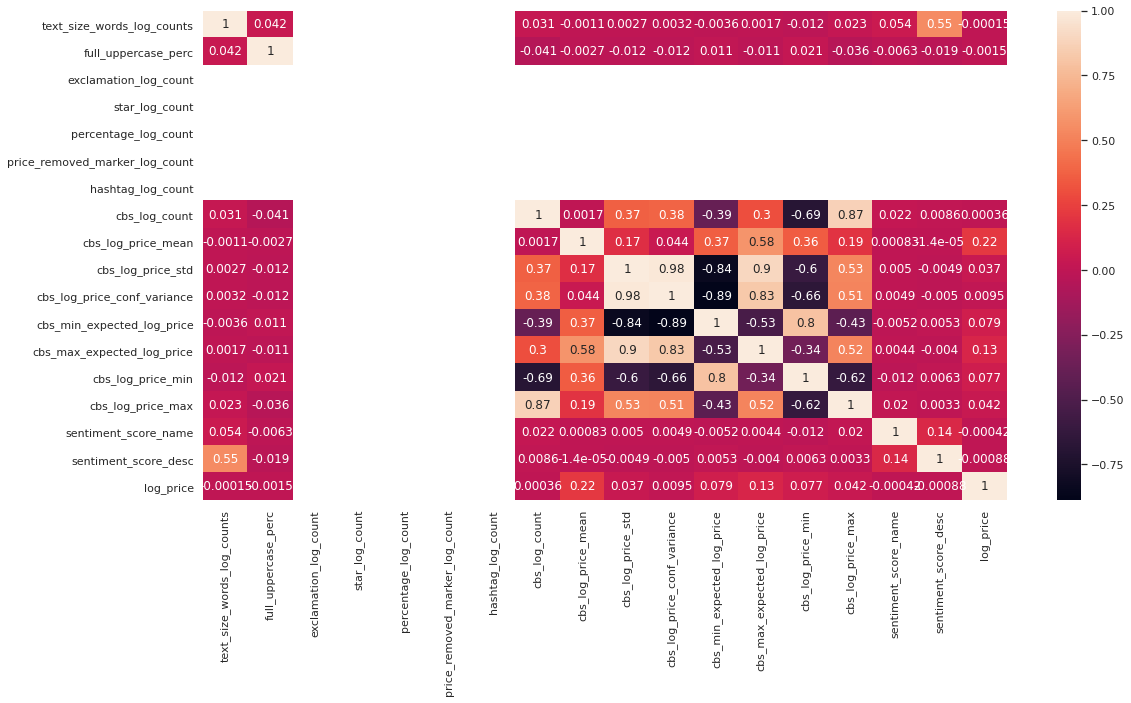

In [65]:
# First Create a Corrleation Matrix using corr method
# Reference : https://datatofish.com/correlation-matrix-pandas/

correlation_matrix = new_df.corr()
plt.figure(figsize = (18,9))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## Observation:
On seeing the Last column we can see that the columns
* cbs_log_price_mean
*cbs_min_expected_log_price
*cbs_max_expected_log_price<br/>
have higher correlation with the Log Price(Target) column
Hence we can use this 3 columns in our Models for Predicting Price. 

In [0]:
# Reference : https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def final_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "log_price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_price_mean',
                                                              'cbs_min_expected_log_price',
                                                              'cbs_max_expected_log_price']].fillna(0).values
    
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [67]:
train_cbs_features = final_cbs_stats(train_data,train_data)
test_cbs_features = final_cbs_stats(train_data,test_data)
print("New Train CBS Features Shape : ", train_cbs_features.shape)
print("New Test CBS Features Shape : ", test_cbs_features.shape)

New Train CBS Features Shape :  (1111244, 3)
New Test CBS Features Shape :  (370416, 3)


So here in both Training and Testing we have two sets of Data
* Initial data given like Name,Description,Shipping etc
* Newly choosen 3 features from the above Heatmap<br/>

So we will now concatenate these two sets of Data into one set and save them in a pickle file for further processing.


In [68]:
train_data.columns

Index(['item_condition_id', 'brand_name', 'price', 'shipping',
       'preprocessed_desc', 'preprocessed_name', 'gencat_name', 'subcat1_name',
       'subcat2_name', 'log_price', 'sentiment_score_name',
       'sentiment_score_desc', 'cat_brand_ship'],
      dtype='object')

In [69]:
# Dropping cat_brand_ship column from training and test data
train_data.drop('cat_brand_ship',axis = 1, inplace = True)
test_data.drop('cat_brand_ship',axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [70]:
print("Train Data Shape : ", train_data.shape)
print("Test Data Shape : ", test_data.shape)
print("Original Data Columns : ", train_data.columns)

Train Data Shape :  (1111244, 12)
Test Data Shape :  (370416, 12)
Original Data Columns :  Index(['item_condition_id', 'brand_name', 'price', 'shipping',
       'preprocessed_desc', 'preprocessed_name', 'gencat_name', 'subcat1_name',
       'subcat2_name', 'log_price', 'sentiment_score_name',
       'sentiment_score_desc'],
      dtype='object')


In [0]:
# Converting Numpy array into a Dataframe
train_cbs_features = pd.DataFrame(train_cbs_features,columns = ['cbs_log_price_mean','cbs_min_expected_log_price','cbs_max_expected_log_price'])
test_cbs_features = pd.DataFrame(test_cbs_features,columns = ['cbs_log_price_mean','cbs_min_expected_log_price','cbs_max_expected_log_price'])

In [0]:
# Merging/Concatenating two datasets into One Dataset(for Training)
train_data['cbs_log_price_mean'] = train_cbs_features.cbs_log_price_mean.values
train_data['cbs_min_expected_log_price'] = train_cbs_features.cbs_min_expected_log_price.values
train_data['cbs_max_expected_log_price'] = train_cbs_features.cbs_max_expected_log_price.values

In [73]:
# Merging/Concatenating two datasets into One Dataset(for Testing)
test_data['cbs_log_price_mean'] = test_cbs_features.cbs_log_price_mean.values
test_data['cbs_min_expected_log_price'] = test_cbs_features.cbs_min_expected_log_price.values
test_data['cbs_max_expected_log_price'] = test_cbs_features.cbs_max_expected_log_price.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [74]:
print("Final Training Data with Price Column Shape : ", train_data.shape)
print("Final Testing Data with Price Column Shape : ", test_data.shape)

Final Training Data with Price Column Shape :  (1111244, 15)
Final Testing Data with Price Column Shape :  (370416, 15)


In [75]:
print("Few Training Data Points : ")
train_data.head()

Few Training Data Points : 


,item_condition_id,brand_name,price,shipping,preprocessed_desc,preprocessed_name,gencat_name,subcat1_name,subcat2_name,log_price,sentiment_score_name,sentiment_score_desc,cbs_log_price_mean,cbs_min_expected_log_price,cbs_max_expected_log_price
1467144,1,missing,172.0,1,shade bewitching betty jet black new in box,nyx gel liner,Beauty,Makeup,Eyes,5.153292,0.0,0.0000,-0.099098,-0.191601,0.061019
72386,1,Sephora,6.0,1,various trial sized skincare items neutrogena ...,skincare bundle,Beauty,SkinCare,Face,1.945910,0.0,0.3182,0.222192,-0.204814,0.357562
428763,3,PINK,12.0,0,no trades,victoria secret pink bralette black,Women,AthleticApparel,SportsBras,2.564949,0.0,-0.2960,-0.102000,-0.055950,-0.054739
704219,3,missing,16.0,0,2 velvet bracelet holders,2 bracelet holder,Beauty,ToolsAccessories,MakeupBrushesTools,2.833213,0.0,0.0000,0.023435,-0.373740,0.321875
710497,3,missing,16.0,1,15 color concealer pallet 3 shades slightly used,morphe brushes concealer pallet,Beauty,Makeup,MakeupPalettes,2.833213,0.0,0.0000,0.007949,-0.251481,0.206108


In [76]:
print("Few Testing Data Points : ")
test_data.head()

Few Testing Data Points : 


,item_condition_id,brand_name,price,shipping,preprocessed_desc,preprocessed_name,gencat_name,subcat1_name,subcat2_name,log_price,sentiment_score_name,sentiment_score_desc,cbs_log_price_mean,cbs_min_expected_log_price,cbs_max_expected_log_price
1297205,3,Cactus,45.0,0,very good condition worn couple times dope shi...,short sleeve button,Men,Tops,ButtonFront,3.828641,0.00,0.1851,1.910288,3.521275,0.817283
1341590,3,Sony,54.0,1,dead rights retribution sony playstation 3 ps3...,free ship dead rights retribution,Electronics,VideoGamesConsoles,Games,4.007333,-0.25,-0.2500,0.100663,-0.044499,0.143555
1100279,1,Tarte,29.0,0,guaranteed authentic i two sale introducing ta...,tartelette bloom clay palette shadow,Beauty,Makeup,Eyes,3.401197,0.00,0.6808,-0.036209,-0.401798,0.132503
22660,3,New Era,4.0,1,very good condition red gray vintage hockey st...,new era red wings snapback,Men,MensAccessories,Hats,1.609438,0.00,0.7574,0.195800,-0.033508,0.259366
700915,3,missing,16.0,0,iphone 6 sim lock i know 2 unlock,iphone 6,Electronics,CellPhonesAccessories,CellPhonesSmartphones,2.833213,0.00,0.0000,0.199450,0.284112,0.119310


In [77]:
# Saving them in a Pickle File
import pickle

file = open("train_data","wb")
pickle.dump(train_data,file)
file.close

file = open("test_data","wb")
pickle.dump(test_data,file)
file.close

<function BufferedWriter.close>